In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML
from collections import deque
import importlib

%load_ext autoreload
%autoreload 2

import simulation
import controller
from simulation import *
from main_bus import MainBus

Using TensorFlow backend.


### Genetic Algorithm

In [14]:
def crossover(par1, par2):
    
    dim_size = len(par1)

    sel = np.random.choice(dim_size, np.random.randint(dim_size), replace = False)

    ch1 = np.zeros(dim_size)
    ch2 = np.zeros(dim_size)

    for ix in range(dim_size):
        if ix in sel:
            ch1[ix] = 0.5*(par1[ix] + par2[ix])
            ch2[ix] = par1[ix]

        else:
            ch1[ix] = par2[ix]
            ch2[ix] = 0.5*(par1[ix] + par2[ix])
    
    ch1[0] = min(3, max(1, int(ch1[0])))
    ch2[0] = min(3, max(1, int(ch1[0])))
                 
    return ch1, ch2


def mutate(par1):
    mut = par1 + np.random.normal(0, 1, par1.shape)
    mut[0,0] = min(3, max(1, int(mut[0,0])))
    return mut[0]


def create_new_population(genomes, fitness, par_pct, child_pct, mut_pct):
    
    # Size of the population
    N = len(genomes)
    
    # Apply softmax probability calculation
    prob_distro =  fitness/ np.sum(fitness)
        
    # Allocate places in the population according to the given probabilities
    num_par = int(np.floor(N * par_pct))
    num_child = int(np.floor(N * child_pct / 2))
    num_mut = int(N - num_par - num_child * 2)
    
    new_pop = []
    
    # Add best parents
    best_par = np.random.choice(N, num_par, replace = False, p = prob_distro)
    for ix in best_par:
        #print(fitness[ix])
        new_pop.append(genomes[ix])
        
    # Match parents and add children
    for ix in range(num_child):
        idx = np.random.choice(N, 2, replace = False, p = prob_distro)
        (ch1, ch2) = crossover(genomes[idx[0]], genomes[idx[1]])
        new_pop.append(ch1)
        new_pop.append(ch2)
        
    # Add mutants
    for ix in range(num_mut):
        par1_idx = np.random.choice(N, 1)
        new_pop.append(mutate(genomes[par1_idx]))
        
    return new_pop, np.ones(N)/N

### Initialization

In [3]:
whole_day = 1440

# Parameters

replay_length = 100000
iterations = 144 # num of ticks before training
epochs = 2000 # num of times network is unfrozen, trained
batch_size = 32 # num of samples from replay memory to train on
animate = False
add_arrivals_noise = False

# Model
loggers = []#StateLogger(bus_id=24, save_every=1)]
simulation = Simulation(MainBus, bus_genomes = [], genome_distro= [], loggers=loggers)
replay_memory = deque(maxlen = replay_length)
training_results = []
training_loss = []
delivered_passeners = []

save_every = 10

Initializing Prob Dist


In [13]:
# Initial iteration
simulation.reset(bus_genomes = [[1, 0, 0, 0, 0], [2, 0, 0, 0, 0], [3, 0, 0, 0, 0]], genome_distro= [0.3, 0.5, 0.2])
simulation.execute(iterations=1440, animate=False, interval=50)
print('\n\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))

bus_fitness = np.array([bus.cum_reward for bus in simulation.controller.buses.values() ])
bus_genomes = np.array([bus.genome for bus in simulation.controller.buses.values() ])

 1440 / 1440 
	delivered:34111


In [15]:

# Evolution
for _ in range(10):
    
    # Evolution step
    (new_genomes, new_distro) = create_new_population(bus_genomes, bus_fitness, 0.35, 0.6, 0.05)
    
    # Evaluation
    simulation.reset(bus_genomes = new_genomes, genome_distro= new_distro)
    simulation.execute(iterations=1440, animate=False, interval=50)
    
    # Get population stats
    bus_fitness = np.array([bus.cum_reward for bus in simulation.controller.buses.values() ])
    bus_genomes = np.array([bus.genome for bus in simulation.controller.buses.values() ])

    # Display results
    print('\n\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))
    
    

 1440 / 1440 
	delivered:33944
 1440 / 1440 
	delivered:33915
 1440 / 1440 
	delivered:32612
 1440 / 1440 
	delivered:32994
 1440 / 1440 
	delivered:34193
 1440 / 1440 
	delivered:33645
 1440 / 1440 
	delivered:34085
 1440 / 1440 
	delivered:35758
 1440 / 1440 
	delivered:34758
 1440 / 1440 
	delivered:33942


In [4]:
print('Buses: ',len(simulation.controller.buses.values()))
for bus in simulation.controller.buses.values():
    print(bus.bus_id -23, bus.genome, bus.cum_reward)

Buses:  30
1 [0, 0, 0, 0] 227
2 [0, 0, 0, 0] 199
3 [-1, 0, 1.1, 1] 215
4 [-1, 0, 1.1, 1] 156
5 [-1, 0, 1.1, 1] 295
6 [0, 0, 0, 0] 227
7 [-1, 0, 1.1, 1] 169
8 [0, 0, 0, 0] 170
9 [-1, 0, 1.1, 1] 212
10 [-1, 0, 1.1, 1] 242
11 [0, 0, 0, 0] 237
12 [0, 0, 0, 0] 220
13 [0, 0, 0, 0] 202
14 [-1, 0, 1.1, 1] 278
15 [0, 0, 0, 0] 229
16 [-1, 0, 1.1, 1] 204
17 [0, 0, 0, 0] 179
18 [-1, 0, 1.1, 1] 219
19 [-1, 0, 1.1, 1] 299
20 [-1, 0, 1.1, 1] 124
21 [-1, 0, 1.1, 1] 199
22 [-1, 0, 1.1, 1] 162
23 [-1, 0, 1.1, 1] 230
24 [0, 0, 0, 0] 203
25 [-1, 0, 1.1, 1] 202
26 [-1, 0, 1.1, 1] 199
27 [-1, 0, 1.1, 1] 206
28 [-1, 0, 1.1, 1] 169
29 [-1, 0, 1.1, 1] 92
30 [-1, 0, 1.1, 1] 201


In [10]:
HTML(simulation.anim.to_html5_video())

1439

In [11]:
print('\r\tdelivered:{}'.format(simulation.controller.num_passengers_delivered))

	delivered:27313


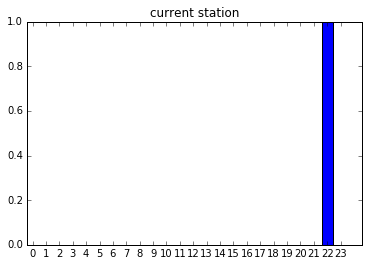

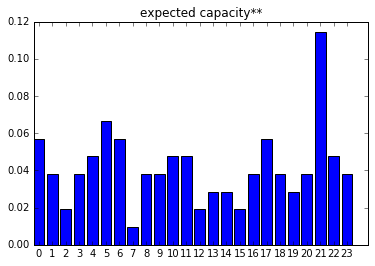

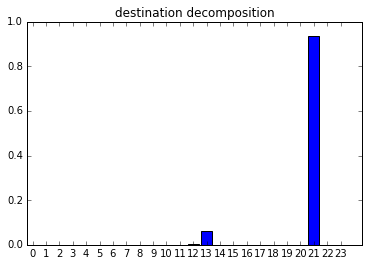

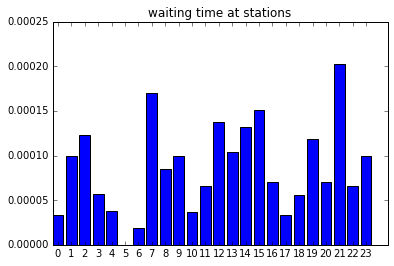

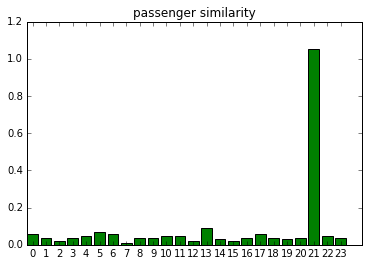

In [5]:
choice = 5


state = simulation.controller.logged_data['Bus 24 State Logger'][choice].T
s = np.zeros((24,1))
titles = ['current station','expected capacity**','destination decomposition','waiting time at stations','passenger similarity']
for i in range(5):
    if i>0:
        s += state[i*24:(i+1)*24] * (0 if i==4 else 1)
        #print(i)
        #print(state[i*24:(i+1)*24])
    
    if i != 4:
        plt.title(titles[i])
        #plt.bar(range(24), s)
        plt.bar(range(24), state[i*24:(i+1)*24])
        plt.xticks(np.array(range(24))+0.4,range(24))
        plt.show()
        
plt.title(titles[i])
plt.bar(range(24), s, color='g')
plt.xticks(np.array(range(24))+0.4,range(24))
plt.show()
    


In [11]:
for i in range(10):
    print(np.random.choice(range(2), p=[0.1, 0.9] ))

1
1
1
0
1
1
1
1
1
1


In [20]:
19.5/20

0.975

In [ ]:
gli 